<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_QuantumEspressoColab_Designing_High_Tc_Superconductors_with_BCS_inspired_Screening%2C_Density_Functional_Theory_and_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Designing High-Tc Superconductors with BCS-inspired Screening, Density Functional Theory and Deep-learning](https://arxiv.org/abs/2205.00060)

In [1]:
!pip install jarvis-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 962 kB 5.6 MB/s 
     |████████████████████████████████| 325 kB 10.1 MB/s 


In [16]:
import os
# Clone the QE git
if not os.path.exists('q-e'):
   os.system('git clone https://github.com/QEF/q-e.git')
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp
! make pw

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
The following NEW packages will be installed:
  libfftw3-3 libfftw3-bin libfftw3-dev libfftw3-doc libfftw3-long3
  libfftw3-quad3 libfftw3-single3
0 upgraded, 7 newly installed, 0 to remove and 49 not upgraded.
Need to get 3,938 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-long3 amd64 3.3.7-1 [308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-single3 amd64 3.3.7-1 [764 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfftw3-3 amd64 3.3.7-1 [1,748 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main a

In [17]:
!make ph

test -d bin || mkdir bin
cd install ; make -f extlibs_makefile libfox
make[1]: Entering directory '/content/q-e/install'
if test ! -d ../FoX; then \
        mkdir ../FoX; \
(gzip -dc ../archive/fox.tgz | (cd ../FoX; tar -xvf -)); \
cd ../FoX/fox/; export FC=gfortran; export FCFLAGS=""; \
./configure --prefix=/content/q-e//FoX ;\
    touch cp_test; \
    if cp -p cp_test cp_test_1; then \
        echo "cp -p works"; \
    else \
        find -type f | xargs sed -i 's/cp -p/cp/g'; \
    fi; \
make install; cd ../; rm -fr fox;fi
make[1]: Leaving directory '/content/q-e/install'
( cd UtilXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/UtilXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/UtilXlib'
cd install ; make -f extlibs_makefile liblapack
make[1]: Entering directory '/content/q-e/install'
make[1]: Nothing to be done for 'liblapack'.
make[1]: Leaving directory '/content/q-e/install'
cd install ; make -f extlibs_makefile

In [21]:
!lscpu 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [26]:
from jarvis.db.figshare import get_jid_data
from jarvis.tasks.qe.super import SuperCond
from jarvis.core.utils import get_factors
from jarvis.core.atoms import Atoms
from jarvis.db.figshare import data, get_jid_data
from jarvis.core.kpoints import Kpoints3D
from jarvis.tasks.queue_jobs import Queue
from jarvis.db.jsonutils import dumpjson
import os
from jarvis.analysis.structure.spacegroup import Spacegroup3D
import glob
from jarvis.db.jsonutils import loadjson

jid = 'JVASP-816' #Aluminum
dat = get_jid_data(jid=jid, dataset="dft_3d")

Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.


In [46]:
def non_prime_kpoints(kpts=[]):
    """Get non prime kpoints."""
    mem = []
    for i in kpts:
        facts = get_factors(i)
        if len(facts) == 1:
            val = i + 1
        else:
            val = i
        mem.append(val)
    return mem

qe_cmd = "/content/q-e/bin/pw.x"
a_atoms = Atoms.from_dict(dat["atoms"])
atoms = Spacegroup3D(a_atoms).refined_atoms.get_primitive_atoms
kp = Kpoints3D().automatic_length_mesh(lattice_mat=atoms.lattice_mat, length=dat["kpoint_length_unit"])
kpts = kp._kpoints[0]
kpts=non_prime_kpoints(kpts)
kp=Kpoints3D(kpoints=[kpts])
print ('kpts',kpts)

nq1 = get_factors(kpts[0])[0]
nq2 = get_factors(kpts[1])[0]
nq3 = get_factors(kpts[2])[0]
qp = Kpoints3D(kpoints=[[nq1, nq2, nq3]])

sup = SuperCond(atoms=atoms, kp=kp, qp=qp,qe_cmd=qe_cmd)

kpts [30, 30, 30]


In [47]:
sup.to_dict()

{'atoms': OrderedDict([('lattice_mat',
               [[0.0, 2.0337054489633575, 2.0337054489633575],
                [2.0337054489633575, 0.0, 2.0337054489633575],
                [2.0337054489633575, 2.0337054489633575, 0.0]]),
              ('coords', [[0.0, 0.0, 0.0]]),
              ('elements', ['Al']),
              ('abc', [2.8761, 2.8761, 2.8761]),
              ('angles', [60.0, 60.0, 60.0]),
              ('cartesian', False),
              ('props', [''])]),
 'kp': OrderedDict([('kpoints', [[30, 30, 30]]),
              ('labels', []),
              ('kpoint_mode', 'automatic'),
              ('header', 'Gamma'),
              ('kpoints_weights', [])]),
 'pressure': None,
 'qe_cmd': '/content/q-e/bin/pw.x',
 'qp': OrderedDict([('kpoints', [[2, 2, 2]]),
              ('labels', []),
              ('kpoint_mode', 'automatic'),
              ('header', 'Gamma'),
              ('kpoints_weights', [])]),
 'relax_calc': "'vc-relax'"}

In [48]:
sup.runjob()

Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/q-e/RELAX.save/data-file-schema.xml
final_strt Al
1.0
1.8171505697137436e-17 2.006703132942441 2.006703132942441
2.006703132942441 1.706249424193977e-17 2.006703132942441
2.006703132942441 2.006703132942441 7.599980977680787e-18
Al
1
Cartesian
0.0 0.0 0.0

Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<ascf_init.in
HERE1
HERE2 /content/q-e/QE.save/data-file-schema.xml
{'out_path': '/content/q-e/scf_init.out', 'xml_path_': 'na', 'total_energy': -90.67321219678706, 'job_done': True, 'xml_path': '/content/q-e/QE.save/data-file-schema.xml'}
Sanitizing Atoms.
cmd /content/q-e/bin/ph.x<aph.in
Exception list index out of range
Sanitizing Atoms.
cmd /content/q-e/bin/q2r.x<aqr.in
Exception list index out of range
Sanitizing Atoms.
cmd /content/q-e/bin/matdyn.x<amatdyn.in
Exception list index out of range
['Broadening', '0.0050', 'lambda', '0.2874', 'dos(Ef)', '2.2985', 'omega_ln', '[K]', '306.4626']
Tc 0.09512770931879173



In [49]:
!ls

a2F.dos1      CMakeLists.txt	     input_tmp.in  phonon.dos	  qr.json
a2F.dos10     configure		     install	   ph.out	  README_GPU.md
a2F.dos2      CONTRIBUTING.md	     KS_Solvers    PP		  README.md
a2F.dos3      COUPLE		     lambda	   pseudo	  relax.json
a2F.dos4      CPV		     LAXlib	   PW		  relax.out
a2F.dos5      dev-tools		     License	   PWCOND	  RELAX.save
a2F.dos6      dft-d3		     logo.jpg	   q2r.out	  RELAX.xml
a2F.dos7      Doc		     LR_Modules    QE333.fc	  scf_init.json
a2F.dos8      dyna2F		     Makefile	   QE333.freq	  scf_init.out
a2F.dos9      elph_dir		     make.inc	   QE333.freq.gp  std.err
amatdyn.in    environment_variables  matdyn.json   QE.a2Fsave	  TDDFPT
aph.in	      EPW		     matdyn.modes  QE.dyn0	  test-suite
aqr.in	      external		     matdyn.out    QE.dyn1	  upflib
archive       FFTXlib		     MBD	   QE.dyn2	  UtilXlib
arelax.in     FoX		     Modules	   QE.dyn3	  XClib
ascf_init.in  GUI		     NEB	   QEHeat	  XSpectra
atomic	      GWW		     _ph0	   QE.save
bi

In [65]:
import os, glob
from jarvis.core.atoms import Atoms
from jarvis.db.jsonutils import loadjson, dumpjson
from jarvis.core.spectrum import Spectrum
from jarvis.io.qe.outputs import DataFileSchema
import numpy as np
import glob

RY_TO_EV = 13.6056980659
def calc_Tc(wlog=300, lamb=1.0, mu=0.1): #mu 0.09
    """Calculate Tc."""

    tc = (wlog / 1.2) * np.exp(
        -1.04 * (1 + lamb) / (lamb - mu * (1 + 0.062 * lamb))
    )
    return tc

def get_a2f(fname="a2F.dos10_JVASP-961"):
    f = open(fname, "r")
    lines = f.read().splitlines()
    f.close()
    x = []
    y = []
    for i in lines:
        tmp = i.split()
        if len(tmp) > 2 and "#" not in i and "lambda" not in i:
            tmp = i.split()
            # print(tmp)
            x.append(1000 * RY_TO_EV * float(tmp[0]))
            y.append(float(tmp[1]))
    return x, y

def parse_lambda(filename="lambda"):
    """Parse lambda file."""
    f = open(filename, "r")
    lines = f.read().splitlines()
    f.close()
    fname = filename.replace("lambda", "QE.save/data-file-schema.xml")
    print("fname", fname)
    ds = DataFileSchema(fname)  
    fname1 = filename.replace("lambda", "a2F.dos10")
    ax, ay = get_a2f(fname1)
    # new_dist = np.arange(0.0, 100, 0.1)
    # new_dist = np.arange(0.0, 100, 0.5)
    new_dist = np.arange(0.0, 100, 1)
    s = Spectrum(x=ax, y=ay)
    interp = s.get_interpolated_values(new_dist=new_dist)

    x = []
    for i in lines:
        if "Broadening" in i and '*****' not in i:
         try:
            tmp = i.split()
            # print(i.split())
            wlog = float(tmp[-1])
            # dos=float(tmp[4])
            lamb = float(tmp[3])
            Tc = calc_Tc(wlog=wlog, lamb=lamb)
            # print("Tc", Tc)
            x.append(Tc)
            # print()
         except Exception as exp:
             print ('Filoename',filename,exp)
             pass
    atoms = ds.final_structure  # .composition.reduced_formula
    # interp=interp/(3*atoms.num_atoms)
    # tc=float(x[-1]))
    return atoms, wlog, lamb, Tc, jid, interp.tolist(),ax,ay
atoms, wlog, lamb, Tc, jid, interp,ax,ay = parse_lambda('./lambda')

fname ./QE.save/data-file-schema.xml


In [66]:
atoms

Al
1.0
0.0 2.0067032774108116 2.0067032774108116
2.0067032774108116 0.0 2.0067032774108116
2.0067032774108116 2.0067032774108116 0.0
Al
1
Cartesian
0.0 0.0 0.0

Text(0, 0.5, 'a2F')

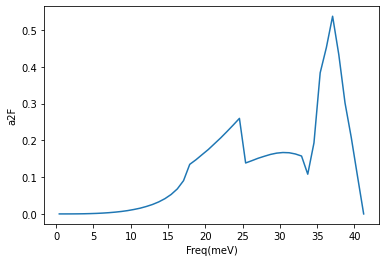

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ax,ay)
plt.xlabel('Freq(meV)')
plt.ylabel('a2F')

In [70]:
print('Tc K:', Tc)

Tc K: 1.692863485136119
